In [ ]:
import os
import torch
import torchaudio
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

CSV_INPUT = "CREMA_dataframe.csv"
CSV_OUTPUT = "crema_with_wav2vec2.csv"
N_FEATURE_DIR = "wav2vec2_cache"

In [ ]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
wav2vec2 = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
wav2vec2.eval()

/Users/snehaghosh/Desktop/Speech Project/.venv/lib/python3.13/site-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [ ]:
# Feature Extraction
def extract_wav2vec2(path):
    waveform, sr = torchaudio.load(path)
    if sr != 16000:
        waveform = torchaudio.functional.resample(waveform, sr, 16000)
    with torch.no_grad():
        inputs = processor(waveform.squeeze(), sampling_rate=16000, return_tensors="pt")
        return wav2vec2(inputs.input_values).last_hidden_state.squeeze(0).cpu().numpy()

def cache_and_save(df, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    paths = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            features = extract_wav2vec2(row['path'])
            path = os.path.join(out_dir, f"feat_{idx}.npy")
            np.save(path, features)
            paths.append(path)
        except Exception as e:
            print(f"Failed: {row['path']} — {e}")
            paths.append(None)
    df['wav2vec2_path'] = paths
    df = df.dropna(subset=['wav2vec2_path']).reset_index(drop=True)
    df.to_csv(CSV_OUTPUT, index=False)
    return df

class Wav2Vec2NpyDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.emo_map = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
        self.int_map = {'Low': 0, 'Medium': 1, 'High': 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = torch.tensor(np.load(row['wav2vec2_path']), dtype=torch.float32)
        emo = torch.tensor(self.emo_map[row['emotion']])
        inten = torch.tensor(self.int_map.get(row['intensity'], 0))
        mask = torch.tensor(1.0 if row['intensity'] != 'Unspecified' else 0.0)
        return x, emo, inten, mask
    
def collate_fn(batch):
    xs, emos, ints, masks = zip(*batch)
    xs = pad_sequence(xs, batch_first=True)
    return xs, torch.stack(emos), torch.stack(ints), torch.stack(masks)

In [ ]:
# Model
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        scores = self.attn(x).squeeze(-1)
        weights = torch.softmax(scores, dim=1)
        return torch.bmm(weights.unsqueeze(1), x).squeeze(1)

class Wav2Vec2BiLSTMAttentionModel(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128, num_emo=6, num_int=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = Attention(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc_emo = nn.Linear(hidden_dim * 2, num_emo)
        self.fc_int = nn.Linear(hidden_dim * 2, num_int)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.attn(x)
        x = self.dropout(x)
        return self.fc_emo(x), self.fc_int(x)

In [ ]:
def masked_crossentropy(emo_pred, emo_true, int_pred, int_true, int_mask):
    ce_emo = nn.CrossEntropyLoss()(emo_pred, emo_true)
    ce_int = nn.CrossEntropyLoss(reduction='none')(int_pred, int_true)
    masked_int = (ce_int * int_mask).mean()
    return ce_emo + masked_int, ce_emo.item(), masked_int.item()

# Training

In [ ]:
def train_model(model, train_loader, test_loader, optimizer, device, epochs=10):
    model.to(device)
    hist = {"train_loss":[],"test_loss":[],"train_emo_acc":[],"test_emo_acc":[],"train_int_acc":[],"test_int_acc":[]}
    for ep in range(epochs):
        model.train()
        tloss, cemo, cint, temo, tint = 0, 0, 0, 0, 0
        for x, e, i, m in train_loader:
            x, e, i, m = x.to(device), e.to(device), i.to(device), m.to(device)
            optimizer.zero_grad()
            epred, ipred = model(x)
            loss, _, _ = masked_crossentropy(epred, e, ipred, i, m)
            loss.backward(); optimizer.step()
            tloss += loss.item()
            cemo += (epred.argmax(1)==e).sum().item()
            mask = m == 1.0
            cint += (ipred.argmax(1)[mask]==i[mask]).sum().item()
            temo += len(e); tint += mask.sum().item()

        model.eval()
        test_loss, test_emo_correct, test_int_correct, test_emo_total, test_int_total = 0, 0, 0, 0, 0
        preds_all, trues_all = [], []
        with torch.no_grad():
            for x, e, i, m in test_loader:
                x, e, i, m = x.to(device), e.to(device), i.to(device), m.to(device)
                epred, ipred = model(x)
                loss, _, _ = masked_crossentropy(epred, e, ipred, i, m)
                test_loss += loss.item()
                p = epred.argmax(1); preds_all.extend(p.cpu()); trues_all.extend(e.cpu())
                test_emo_correct += (p==e).sum().item()
                mask = m == 1.0
                test_int_correct += (ipred.argmax(1)[mask]==i[mask]).sum().item()
                test_emo_total += len(e); test_int_total += mask.sum().item()

        hist["train_loss"].append(tloss/len(train_loader))
        hist["test_loss"].append(test_loss/len(test_loader))
        hist["train_emo_acc"].append(cemo/temo*100)
        hist["test_emo_acc"].append(test_emo_correct/test_emo_total*100)
        hist["train_int_acc"].append(cint/tint*100 if tint > 0 else 0)
        hist["test_int_acc"].append(test_int_correct/test_int_total*100 if test_int_total > 0 else 0)

        print(f"Epoch {ep+1}: Train Loss {tloss:.2f}, Test Loss {test_loss:.2f}, Test Emo Acc: {hist['test_emo_acc'][-1]:.2f}%, Int Acc: {hist['test_int_acc'][-1]:.2f}%")

    cm = confusion_matrix(trues_all, preds_all)
    ConfusionMatrixDisplay(cm, display_labels=['angry','disgust','fear','happy','neutral','sad']).plot(cmap='viridis')
    plt.title("Emotion Confusion Matrix"); plt.show()

    # Plot
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(hist['train_loss'], label='Train'); plt.plot(hist['test_loss'], label='Test')
    plt.title("Loss"); plt.legend()
    plt.subplot(1,3,2)
    plt.plot(hist['train_emo_acc'], label='Train'); plt.plot(hist['test_emo_acc'], label='Test')
    plt.title("Emotion Accuracy"); plt.legend()
    plt.subplot(1,3,3)
    plt.plot(hist['train_int_acc'], label='Train'); plt.plot(hist['test_int_acc'], label='Test')
    plt.title("Intensity Accuracy"); plt.legend()
    plt.tight_layout(); plt.show()


100%|██████████| 7442/7442 [10:33<00:00, 11.74it/s]
/var/folders/n2/k8hqpn8j2tngb4tsghzlb1t40000gn/T/ipykernel_49729/3398438556.py:6: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Scalar.cpp:23.)
  return ce_emo + masked_int, ce_emo.item(), masked_int.item()


Epoch 1: Train Loss 1248.98, Test Loss 279.85, Test Emo Acc: 48.62%, Int Acc: 55.19%
Epoch 2: Train Loss 1109.29, Test Loss 264.32, Test Emo Acc: 52.18%, Int Acc: 54.44%
Epoch 3: Train Loss 1060.05, Test Loss 254.16, Test Emo Acc: 55.07%, Int Acc: 52.59%
Epoch 4: Train Loss 1013.56, Test Loss 257.62, Test Emo Acc: 53.32%, Int Acc: 57.41%
Epoch 5: Train Loss 975.06, Test Loss 249.21, Test Emo Acc: 55.61%, Int Acc: 54.81%
Epoch 6: Train Loss 945.34, Test Loss 240.23, Test Emo Acc: 57.69%, Int Acc: 58.15%
Epoch 7: Train Loss 913.71, Test Loss 238.19, Test Emo Acc: 59.10%, Int Acc: 51.11%
Epoch 8: Train Loss 889.77, Test Loss 236.62, Test Emo Acc: 58.70%, Int Acc: 49.63%
Epoch 9: Train Loss 862.89, Test Loss 236.45, Test Emo Acc: 58.63%, Int Acc: 51.85%
Epoch 10: Train Loss 833.90, Test Loss 233.03, Test Emo Acc: 59.91%, Int Acc: 50.37%


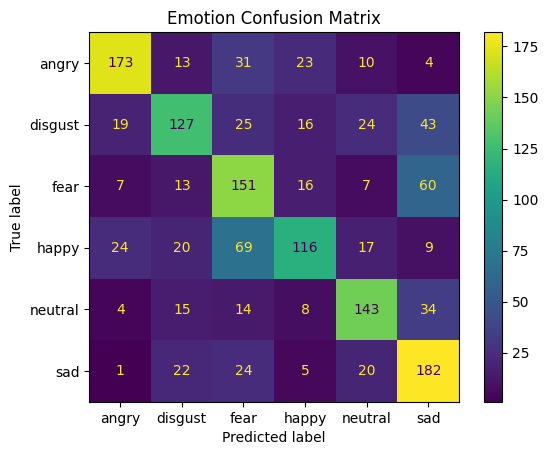

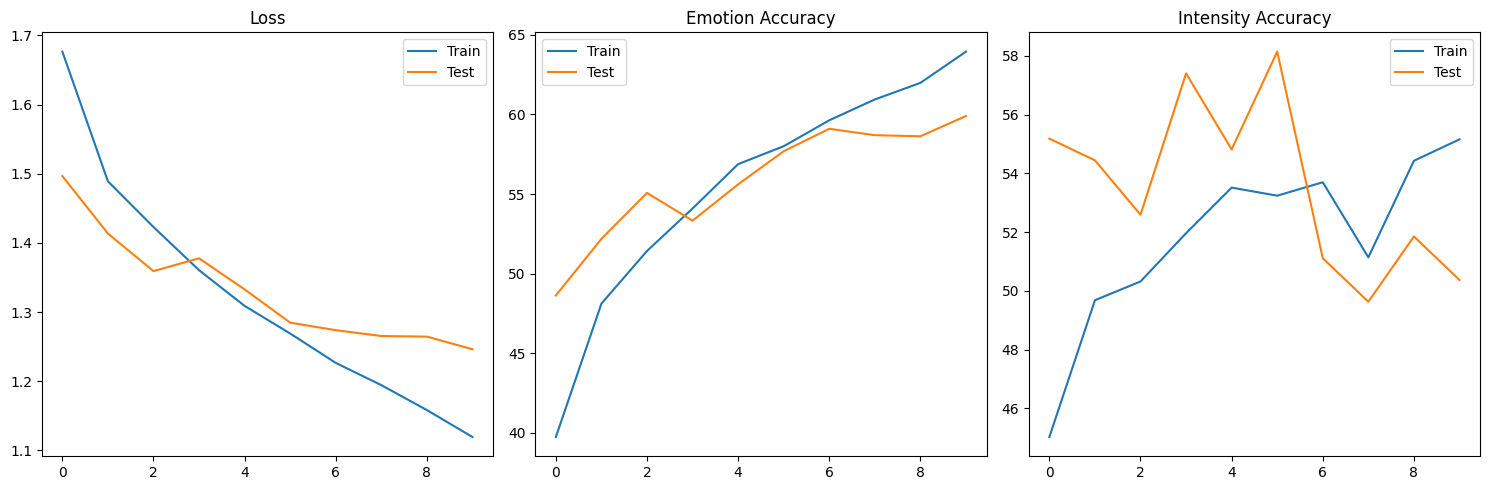

In [ ]:
if __name__ == "__main__":
    # Load and cache features
    df = pd.read_csv(CSV_INPUT)
    df = cache_and_save(df, N_FEATURE_DIR)

    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)

    train_ds = Wav2Vec2NpyDataset(train_df)
    test_ds = Wav2Vec2NpyDataset(test_df)
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)

    model = Wav2Vec2BiLSTMAttentionModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_model(model, train_loader, test_loader, optimizer, device, epochs=10)

# Testing

In [36]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_emo_preds, all_emo_trues = [], []
    all_int_preds, all_int_trues = [], []

    with torch.no_grad():
        for x, emo_true, int_true, _ in test_loader:
            x = x.to(device)
            emo_pred, int_pred = model(x)

            all_emo_preds.extend(torch.argmax(emo_pred, dim=1).cpu().numpy())
            all_emo_trues.extend(emo_true.numpy())
            all_int_preds.extend(torch.argmax(int_pred, dim=1).cpu().numpy())
            all_int_trues.extend(int_true.numpy())

    return all_emo_preds, all_emo_trues, all_int_preds, all_int_trues

In [37]:
emo_preds, emo_trues, int_preds, int_trues = evaluate_model(model, test_loader, device)

In [39]:
from sklearn.metrics import classification_report

emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
intensity_labels = ['Low', 'Medium', 'High']

print("Emotion Classification Report:")
print(classification_report(emo_trues, emo_preds, target_names=emotion_labels))

# Filter out unspecified intensity values
int_filtered = [(p, t) for p, t in zip(int_preds, int_trues) if t in [0, 1, 2]]
if int_filtered:
    p_filtered, t_filtered = zip(*int_filtered)
    print("Intensity Classification Report:")
    print(classification_report(t_filtered, p_filtered, target_names=intensity_labels))
else:
    print("No valid intensity labels to evaluate.")

Emotion Classification Report:
              precision    recall  f1-score   support

       angry       0.76      0.68      0.72       254
     disgust       0.60      0.50      0.55       254
        fear       0.48      0.59      0.53       254
       happy       0.63      0.45      0.53       255
     neutral       0.65      0.66      0.65       218
         sad       0.55      0.72      0.62       254

    accuracy                           0.60      1489
   macro avg       0.61      0.60      0.60      1489
weighted avg       0.61      0.60      0.60      1489

Intensity Classification Report:
              precision    recall  f1-score   support

         Low       0.93      0.51      0.66      1313
      Medium       0.06      0.22      0.09        78
        High       0.13      0.62      0.22        98

    accuracy                           0.51      1489
   macro avg       0.37      0.45      0.32      1489
weighted avg       0.83      0.51      0.60      1489

